# Test Linear Scaling & GENE EXPRESSION PROGRAMMING 

# Can we Evolve Pi using Linear Scaling ??

# Improving symbolic regression with linear scaling
Generally, if the constants in a mathematical model are continuous real numbers, then it is difficult for both GP/GEP to find the true value of such constants. In many cases, GEP can obtain the true *structure* of the model very quickly, after which it will spend much more time in optimizing the constants. However, even with the [GEP-RNC](numerical_expression_inference-RNC.ipynb) algorithm proposed by Cândida Ferreira, it is still quite difficult for GEP to locate a good value for the constants, even after a lot of efforts have been spent by GEP.

In the paper *Improving Symbolic Regression with Interval Arithmetic and Linear Scaling* and [*Scaled Symbolic Regression*](https://www.researchgate.net/publication/220286036_Scaled_Symbolic_Regression), a simple yet effective method is developed to improve symbolic regression of arbitrary mathematical expressions. The intuition of this method is that **by rescaling the expression found by GEP/GP to the optimal slope and intercept, it will focus its search on expressions that are close in shape with the target, instead of demanding that first the scale is correct. Thus, GEP/GP will focus on the construction of the model structure, which it is extremely good at, and the linear scaling technique can help find the constant coefficients.**

We only need to change the evaluation routine when implementing the linear scaling technique. Instead of the original mean squared error (MSE) objective, first rescale the model by determining a pair of weights $(a, b)$ to 
\begin{equation}
min_{a,b} \quad \frac{1}{N} \sum_{i=1}^N (y_i - (ay_{pi}+b))^2
\end{equation}
where $y_i$ and $y_{pi}$ are the true value and predicted value for the $i^{th}$ example's target variable.

Thus, if the best model found by GEP finally is $g(x)$, then the scaled model is $ag(x)+b$.

In [1]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

# for reproduction
s = 10
random.seed(s)
np.random.seed(s)

# https://stackoverflow.com/questions/20314324/precision-in-python-upto-50-decimal-places
from decimal import *   # I am increasing precision using decimal to 50 places
import math
context = Context(prec=50)
setcontext(context)

# Synthetic dataset

For this simple task, we first choose a ground truth function $f$ to generate a dataset $D$. Then, 50 input-output exampels are generated randomly.

In [2]:
def f(x):
    """Ground truth function"""
    return math.pi*(x**2)                  ## area of a circle

    #return (4/3)*(math.pi)*(x**3)         ## volume of a sphere

In [3]:
n_cases = 1000
X = np.random.uniform(-10, 10, size=n_cases)   # random numbers in range [-10, 10)
Y = f(X) + np.random.normal(size=n_cases)   # Gaussian noise
Y = f(X)

In [6]:
print(Y)

[9.25072009e+01 2.88622759e+02 2.24458636e+01 7.77900714e+01
 2.80105942e-03 9.51737783e+01 1.14562617e+02 8.52958139e+01
 1.37586224e+02 2.12954879e+02 4.31758657e+01 2.58321259e+02
 3.09217317e+02 1.86800716e-01 1.22813484e+02 1.59116839e+01
 6.17956563e+01 5.44319519e+01 2.19327423e+02 5.78590472e+01
 2.27454230e+00 1.60902668e+02 2.01596793e+01 3.81043973e+01
 4.25168020e+00 5.47159013e+00 1.74283763e+01 2.16912418e-01
 2.84242662e+01 1.28288445e+01 1.17069816e+02 5.88859130e-01
 2.09850734e+02 4.10613593e+01 2.10767622e+02 4.99142115e+01
 1.87249067e+02 1.35756279e+02 2.57991290e+02 2.00414056e+01
 2.84558204e+00 1.28106842e+02 1.13892264e+02 1.60022851e+02
 2.76547356e+01 8.14871917e+01 5.23158430e+01 1.85237376e+02
 3.82598089e+01 1.41012710e+02 1.45141121e+01 2.07690021e+02
 1.29570394e+02 1.52926338e+02 1.68759584e+01 2.48019416e+02
 2.98801406e+02 2.39928785e+00 1.33651029e+02 7.76787952e+01
 1.19144749e+01 2.03918803e+02 1.50074110e+00 1.02243584e+01
 2.66735404e+02 2.563168

# Creating the primitives set
The first step in GEP (or GP as well) is to specify the primitive set, which contains the elementary building blocks to formulate the model. For this problem, we have:
+ function set: the standard arithmetic operators addition (+), subtraction (-), multiplication (*), and division (/).
+ terminal set: only the single input 'x' and random numerical constants (RNC).

NOTE:

- We define a *protected division* to avoid dividing by zero.
- Even there may be multiple RNCs in the model, we only need to call `PrimitiveSet.add_rnc` once.

In [7]:
def protected_div(a, b):
    if np.isscalar(b):
        if abs(b) < 1e-6:
            b = 1
    else:
        b[abs(b) < 1e-6] = 1
    return a / b

In [8]:
import operator 

pset = gep.PrimitiveSet('Main', input_names=['x'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_ephemeral_terminal(name='enc', gen=lambda: random.uniform(-5, 5)) # each ENC is a random integer within [-10, 10]

# Create the individual and population
Our objective is to **minimize** the MSE (mean squared error) for data fitting.
## Define the indiviudal class, a subclass of *gep.Chromosome*

In [9]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin, a=float, b=float)

## Register the individual and population creation operations
In DEAP, it is recommended to register the operations used in evolution into a *toolbox* to make full use of DEAP functionality. The configuration of individuals in this problem is:
+ head length: 6
+ number of genes in each chromosome: 2

Generally, more complicated problems require a larger head length and longer chromosomes formed with more genes.

In [10]:
h = 7 # head length
n_genes = 2   # number of genes in a chromosome

# TOGGLE Linear Scaling ON / OFF here:

In [11]:
# whether enable linear scaling
LINEAR_SCALING = True

### above, we can toggle the switch to use linear scaling or not - which should to improve final outputs discovered through evolution of the equations. This helps us compare how well LS works to improve GEP.

In [12]:
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

# Define the fitness evaluation function
In DEAP, the single objective optimization problem is just a special case of more general multiobjective ones. Since *geppy* is built on top of DEAP, it conforms to this convention. **Even if the fitness only contains one measure, keep in mind that DEAP stores it as an iterable.** 

Knowing that, you can understand why the evaluation function must return a tuple value (even if it is a 1-tuple). That's also why we set ``weights=(-1,)`` when creating the ``FitnessMax`` class.

In [13]:
def evaluate(individual):
    """Evalute the fitness of an individual: MSE (mean squared error)"""
    func = toolbox.compile(individual)
    Yp = func(X)   # predictions with the GEP model
    return np.mean((Y - Yp) ** 2),

In [14]:
def evaluate_linear_scaling(individual):
    """Evaluate the fitness of an individual with linearly scaled MSE.
    Get a and b by minimizing (a*Yp + b - Y)"""
    func = toolbox.compile(individual)
    Yp = func(X)
    
    # special cases: (1) individual has only a terminal 
    #  (2) individual returns the same value for all test cases, like 'x - x + 10'. np.linalg.lstsq will fail in such cases.
    
    if isinstance(Yp, np.ndarray):
        Q = np.hstack((np.reshape(Yp, (-1, 1)), np.ones((len(Yp), 1))))
        (individual.a, individual.b), residuals, _, _ = np.linalg.lstsq(Q, Y, rcond=None)   
        # residuals is the sum of squared errors
        if residuals.size > 0:
            return residuals[0] / len(Y),   # MSE
    
    # for the above special cases, the optimal linear scaling is just the mean of true target values
    individual.a = 0
    individual.b = np.mean(Y)
    return np.mean((Y - individual.b) ** 2),

In [15]:
if LINEAR_SCALING:
    toolbox.register('evaluate', evaluate_linear_scaling)
else:
    toolbox.register('evaluate', evaluate)

# Register genetic operators
Compared with GP and other genetic algorithms, GEP has its own set of genetic operators aside from common mutation and crossover. For details, please check the tutorial [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html).

In the following code, the selection operator is ``tools.selTournament`` provided by DEAP, while all other operators are specially designed for GEP in *geppy*.

In [16]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.4)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
toolbox.register('mut_ephemeral', gep.mutate_uniform_ephemeral, ind_pb='1p')  # 1p: expected one point mutation in an individual
toolbox.pbs['mut_ephemeral'] = 1  # we can also give the probability via the pbs property

# Statistics to be inspected
We often need to monitor of progress of an evolutionary program. DEAP offers two classes to handle the boring work of recording statistics. Details are presented in [Computing statistics](http://deap.readthedocs.io/en/master/tutorials/basic/part3.html). In the following, we are intereted in the average/standard deviation/min/max of all the individuals' fitness in each generation.

In [17]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Launch evolution
We make use of *geppy*'s builtin algorithm ``gep_rnc`` here to perform the GEP-RNC evolution. A special class from DEAP, `HallOfFame`, is adopted to store the best individuals ever found. Besides, it should be noted that in GEP [*elitism*](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism) is highly recommended because some genetic operators in GEP are destructive and may destroy the best individual we have evolved.

In [18]:
# size of population and number of generations
n_pop = 1000
n_gen = 50

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(3)   # only record the best three individuals ever found in all generations

# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg    	std    	min        	max    
0  	1000  	7701.89	2606.81	1.53985e-28	8743.13
1  	999   	6766.16	3370.82	1.53985e-28	8743.13
2  	999   	5355.94	3879.88	1.53985e-28	8743.13
3  	999   	3938.35	3956.25	1.53985e-28	8743.13
4  	999   	3218.47	3867.38	1.52188e-28	8743.13
5  	999   	2781.47	3794.97	1.52188e-28	8743.13
6  	999   	2820.93	3842.63	1.48596e-28	8743.13
7  	999   	2453.01	3710.89	1.48596e-28	8743.13
8  	999   	2249.12	3608.4 	1.48596e-28	8743.13
9  	999   	1800.13	3355.13	1.41302e-28	8743.13
10 	999   	1655.02	3255.69	1.41302e-28	8743.13
11 	999   	1728.44	3359.13	1.41302e-28	8743.13
12 	999   	1980.24	3531.54	1.41302e-28	8743.13
13 	999   	1967.09	3538.46	1.29475e-28	8743.13
14 	999   	1903.24	3486.94	1.29475e-28	8743.13
15 	999   	2098.62	3613.13	1.29475e-28	8743.13
16 	999   	2001.61	3547.75	1.29475e-28	8743.13
17 	999   	2251.25	3704.12	1.29475e-28	8743.13
18 	999   	1991.59	3549.36	1.29475e-28	8743.13
19 	999   	1925.46	3505.29	1.29475e-28	8743.13
20 	999   	20

**Let's check the best individuals ever evolved.**

In [19]:
print(hof[0])

add(
	mul(-2.6461569577734076, 2.4958210728408394),
	mul(x, x)
)


# *[optional]* Post-processing: simplification and visualization
## Symbolic simplification of the final solution
The original solution seems a little complicated, which may contain many redundancies, for example, `protected_div(x, x)` is just 1. We can perform symbolic simplification of the final result by `geppy.simplify` which depends on `sympy` package.

In [20]:
for i in range(1):
    ind = hof[i]
    symplified_model = gep.simplify(ind)
    raw_non_sym_model = gep.simplify(ind)
    if LINEAR_SCALING:
        symplified_model = ind.a * symplified_model + ind.b
    print('Symplified best individual {}: '.format(i))
    print(symplified_model)
    # real value of pi is 3.14159265358979323846264338327950288419716939937510
    # our GEP estimate is:3.141592653589 8
    # our GEP estimate is:

Symplified best individual 0: 
3.1415926535898*x**2 - 7.105427357601e-15


In [21]:
# print(raw_non_sym_model)  # this is the raw model without linear scaling:


As we can see from the above simplified expression, the *truth model* has been successfully found. Due to the existence of Gaussian noise, the minimum mean absolute error （MAE) is still not zero even the best individual represents the true model.

## Visualization
If you are interested in the expression tree corresponding to the individual, i.e., the genotype/phenotype system, *geppy* supports tree visualization by the `graph` and the `export_expression_tree` functions:

- `graph` only outputs the nodes and links information to describe the tree topology, with which you can render the tree with tools you like;
- `export_expression_tree` implements tree visualization with data generated by `graph` internally using the `graphviz` package. 

In [22]:
 # we want use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
best_ind = hof[0]
gep.export_expression_tree(best_ind, rename_labels, 'data/numerical_expression_tree.png')

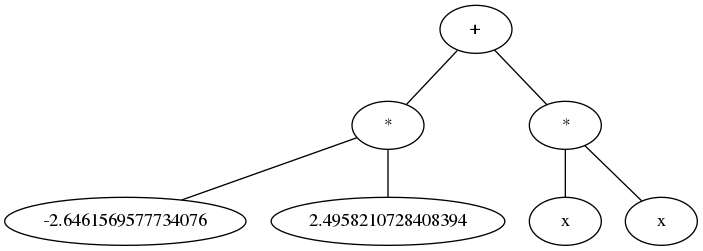

In [23]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png') 

# Discussion
**With the given no-noise data, a normal GEP can only find a model with $MSE=52.0646$, though the model structure is right. By contrast, linear scaling-enabled GEP obtains a solution with $MSE=2.03544e^{-5}$, which is qualified to be considered as the true model.**

If only integer constants are involved, then the GEP-RNC algorithm and the ENC-based algorithm can both be adopted. However, generally the GEP-RNC algorithm is more effective.

In other cases where the model is more complicated involving real coefficients and constants, then both of the above two algorithms will have difficulty in optimizing these constants. A better way is to incorporate a local optimizater into GEP dedicated to constant number optimization, or use other techniques like the linear scaling here. 